In [4]:
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import torchvision.transforms as transforms
import cv2
from tqdm import tqdm
import os
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import torchvision.models as models
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights

# CSV Reading and Directory Creation

In [3]:
# Reading the CSV file
csv_file = 'dataset/label_final_images.csv'
image_dir = 'dataset/processed_images/'
deeplabv3_mask_dir = 'dataset/deeplabv3_masks/'
maskrcnn_mask_dir = 'dataset/maskrcnn_masks/'

# Ensure mask directories exist
os.makedirs(deeplabv3_mask_dir, exist_ok=True)
os.makedirs(maskrcnn_mask_dir, exist_ok=True)

# CSV Loading and Image Name Standardization

In [6]:
# Loading CSV data
df = pd.read_csv(csv_file)

# Checking and standardizing image names
df['image_name'] = df['image_name'].apply(lambda x: x if x.endswith('.jpg') else f'{x}.jpg')
df


image_name    patient_id     sex  age_approx  \
0       ISIC_100041.jpg  Patient_9176  female        31.0   
1       ISIC_100080.jpg  Patient_9434  female        50.0   
2       ISIC_100092.jpg  Patient_3088    male        47.0   
3       ISIC_100188.jpg  Patient_3739  female        62.0   
4       ISIC_100411.jpg  Patient_2697  female        45.0   
...                 ...           ...     ...         ...   
15945  ISIC_2532544.jpg    IP_6353955    male        55.0   
15946  ISIC_2532643.jpg    IP_3358218  female        45.0   
15947  ISIC_2532945.jpg    IP_5874294    male        70.0   
15948  ISIC_2533114.jpg    IP_4186145    male        50.0   
15949  ISIC_2535382.jpg    IP_0612651  female        25.0   

      anatom_site_general_challenge         diagnosis benign_malignant  target  
0                   lower extremity  random_diagnosis        malignant       1  
1                   upper extremity  random_diagnosis        malignant       1  
2                   upper extremity  random_diagnosis        malignant       1  
3                   upper extremity  random_diagnosis        malignant       1  
4                   upper extremity  random_diagnosis        malignant       1  
...                             ...               ...              ...     ...  
15945               lower extremity           unknown           benign       0  
15946               lower extremity           unknown           benign       0  
15947                         torso           unknown           benign       0  
15948                         torso             nevus           benign       0  
15949                     head/neck           unknown           benign       0  

[15950 rows x 8 columns]

# Image Channel Count Verification

In [7]:
# Checking the number of channels in all images
for index, row in tqdm(df.iterrows(), total=len(df), desc='Processing images'):
    image_name = row['image_name']
    
    image_path = os.path.join(image_dir, image_name)

    # Open the image
    image = Image.open(image_path)
    num_channels = len(image.getbands())

    # Check if the image has more than three channels
    if num_channels > 3:
        print(f'Image {image_name} has more than three channels.')

Processing images: 100%|██████████| 15950/15950 [00:03<00:00, 4306.20it/s]


# Load Pre-trained DeepLabV3 Model

In [8]:
# Loading the pre-trained DeepLabV3 model with specified weights
weights = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
model = models.segmentation.deeplabv3_resnet101(weights=weights)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# Preprocess Images and Generate Masks with DeepLabV3 Pretrained Model

In [ ]:
# Define transformations for image preprocessing
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard values for ImageNet models
])

# Function to save masks
def save_mask(mask, output_path):
    mask = (mask > 0.5).astype(np.uint8) * 255  # Convert to binary mask
    cv2.imwrite(output_path, mask)

# Set up device for CUDA usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Process images and generate masks for cancerous images
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Images"):
    if row['target'] == 1:  # Only cancerous images
        image_path = os.path.join(image_dir, row['image_name'])
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        input_tensor = preprocess(image_rgb).to(device)
        input_batch = input_tensor.unsqueeze(0)
        
        with torch.no_grad():
            output = model(input_batch)['out'][0]
        output_predictions = output.argmax(0).cpu().numpy()

        # Save mask
        mask_path = os.path.join(deeplabv3_mask_dir, f"mask_{row['image_name']}")
        save_mask(output_predictions, mask_path)

print("Masks for cancerous images have been generated and saved.")

# Download Pre-trained Mask R-CNN Model

In [9]:
# Download pre-trained Mask R-CNN model with specified weights
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.COCO_V1)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

# Preprocess and Predict Masks with Mask R-CNN

In [ ]:
# Preprocessing transformations
preprocess = T.Compose([
    T.ToTensor(),
])

# Function to predict mask
def predict_mask(image_path):
    input_image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Move model and input to CUDA if available
    if torch.cuda.is_available():
        model.to('cuda')
        input_batch = input_batch.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    return input_image, output

# Function to save masks
def save_mask(mask, output_path):
    mask = (mask * 255).astype(np.uint8)  # Convert mask to binary
    cv2.imwrite(output_path, mask)

# Set up device for CUDA usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Images"):
    if row['target'] == 1:  # Only cancerous images
        image_path = os.path.join(image_dir, row['image_name'])
        image, output = predict_mask(image_path)

        # Check if the model detected any object or mask
        if len(output[0]['scores']) > 0:
            # Select the mask with the highest score
            scores = output[0]['scores'].cpu().numpy()
            best_mask_idx = np.argmax(scores)
            best_mask = output[0]['masks'][best_mask_idx, 0].cpu().numpy()

            # Save the mask with the highest score
            mask_path = os.path.join(maskrcnn_mask_dir, f"mask_{row['image_name']}")
            save_mask(best_mask, mask_path)

print("Masks for cancerous images have been generated and saved.")

# Check Mask Directory and Update DataFrame

In [10]:
# Check if directory exists and get list of mask files
if os.path.exists(maskrcnn_mask_dir):
    mask_files = os.listdir(maskrcnn_mask_dir)
else:
    mask_files = []

# Add new column to DataFrame to indicate if mask exists
df['mask_exists'] = df['image_name'].apply(lambda x: f"mask_{x}" in mask_files)
df

image_name    patient_id     sex  age_approx  \
0       ISIC_100041.jpg  Patient_9176  female        31.0   
1       ISIC_100080.jpg  Patient_9434  female        50.0   
2       ISIC_100092.jpg  Patient_3088    male        47.0   
3       ISIC_100188.jpg  Patient_3739  female        62.0   
4       ISIC_100411.jpg  Patient_2697  female        45.0   
...                 ...           ...     ...         ...   
15945  ISIC_2532544.jpg    IP_6353955    male        55.0   
15946  ISIC_2532643.jpg    IP_3358218  female        45.0   
15947  ISIC_2532945.jpg    IP_5874294    male        70.0   
15948  ISIC_2533114.jpg    IP_4186145    male        50.0   
15949  ISIC_2535382.jpg    IP_0612651  female        25.0   

      anatom_site_general_challenge         diagnosis benign_malignant  \
0                   lower extremity  random_diagnosis        malignant   
1                   upper extremity  random_diagnosis        malignant   
2                   upper extremity  random_diagnosis        malignant   
3                   upper extremity  random_diagnosis        malignant   
4                   upper extremity  random_diagnosis        malignant   
...                             ...               ...              ...   
15945               lower extremity           unknown           benign   
15946               lower extremity           unknown           benign   
15947                         torso           unknown           benign   
15948                         torso             nevus           benign   
15949                     head/neck           unknown           benign   

       target  mask_exists  
0           1         True  
1           1         True  
2           1         True  
3           1         True  
4           1         True  
...       ...          ...  
15945       0        False  
15946       0        False  
15947       0        False  
15948       0        False  
15949       0        False  

[15950 rows x 9 columns]

# Split Data and Filter by Mask

In [25]:
# Split data into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Filter data to include only those with masks
train_df = train_df[train_df['mask_exists'] == True]
val_df = val_df[val_df['mask_exists'] == True]
test_df = test_df[test_df['mask_exists'] == True]


# Define ClassificationDataset for Image Loading and Preprocessing

In [14]:
class ClassificationDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        # Initialize with DataFrame, image directory, and optional transforms
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        # Return the length of the DataFrame
        return len(self.df)

    def __getitem__(self, idx):
        # Retrieve image name and label from DataFrame
        image_name = self.df.iloc[idx]['image_name']
        label = self.df.iloc[idx]['target']
        image_path = os.path.join(self.image_dir, image_name)

        # Read and preprocess the image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        return image, label


# Create Datasets and Data Loaders for Classification

In [26]:
# Create datasets for training, validation, and test sets
train_dataset_cls = ClassificationDataset(train_df, image_dir, transform=None)
val_dataset_cls = ClassificationDataset(val_df, image_dir, transform=None)
test_dataset_cls = ClassificationDataset(test_df, image_dir, transform=None)

# Create data loaders for training, validation, and test sets
train_loader_cls = DataLoader(train_dataset_cls, batch_size=16, shuffle=True)
val_loader_cls = DataLoader(val_dataset_cls, batch_size=16, shuffle=False)
test_loader_cls = DataLoader(test_dataset_cls, batch_size=16, shuffle=False)


# Configure Device and Initialize ResNet Classifier

In [27]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the ResNet classifier
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetClassifier, self).__init__()
        # Use the weights parameter instead of pretrained
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Instantiate the model, loss function, and optimizer
classifier = ResNetClassifier(num_classes=2).to(device)
loss_fn_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classifier.parameters(), lr=1e-3)


# Train ResNet Classifier and Evaluate Loss per Epoch

In [18]:
num_epochs = 10

for epoch in range(num_epochs):
    classifier.train()  # Set the model to training mode
    train_loss = 0.0
    
    for images, labels in train_loader_cls:
        images, labels = images.to(device), labels.to(device)
        
        optimizer_cls.zero_grad()  # Zero the gradients
        outputs = classifier(images)  # Forward pass
        
        loss = loss_fn_cls(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer_cls.step()  # Update weights
        
        train_loss += loss.item() * images.size(0)  # Accumulate training loss
    
    train_loss /= len(train_loader_cls.dataset)  # Calculate average training loss
    
    classifier.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader_cls:
            images, labels = images.to(device), labels.to(device)
            
            outputs = classifier(images)  # Forward pass
            loss = loss_fn_cls(outputs, labels)  # Compute loss
            
            val_loss += loss.item() * images.size(0)  # Accumulate validation loss
    
    val_loss /= len(val_loader_cls.dataset)  # Calculate average validation loss
    
    # Print the training and validation loss for the current epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')


Epoch 1/10, Train Loss: 0.10876291547749697, Val Loss: 0.09275073669913123
Epoch 2/10, Train Loss: 0.10405250493882486, Val Loss: 0.10413600529005197
Epoch 3/10, Train Loss: 0.10387004616912629, Val Loss: 0.0968767840673767
Epoch 4/10, Train Loss: 0.10166026483161857, Val Loss: 0.08571391582588687
Epoch 5/10, Train Loss: 0.10095436634254787, Val Loss: 0.09280380678544581
Epoch 6/10, Train Loss: 0.1028929701060256, Val Loss: 0.10620724920109055
Epoch 7/10, Train Loss: 0.09915904938670829, Val Loss: 0.09460590946422671
Epoch 8/10, Train Loss: 0.0983438390016429, Val Loss: 0.09197194234975754
Epoch 9/10, Train Loss: 0.09298691026169091, Val Loss: 0.0979121016466174
Epoch 10/10, Train Loss: 0.09601367053259256, Val Loss: 0.09002543951931369


# Save Trained Model Weights

In [20]:
# Save the trained model weights
torch.save(classifier.state_dict(), 'resnet_classifier.pth')


# Define U-Net Model and Optimizer

In [62]:
# Define the U-Net model using ResNet34 as the encoder with ImageNet weights
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
model = model.to(device)

# Define the loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Define SkinLesionDataset for Image and Mask Loading

In [63]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, image_dir, mask_dir, transform=None):
        # Initialize with DataFrame, image directory, mask directory, and optional transforms
        self.df = df
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        # Return the length of the DataFrame
        return len(self.df)

    def __getitem__(self, idx):
        # Retrieve image name from the DataFrame
        image_name = self.df.iloc[idx]['image_name']
        
        # Construct the full path to the image and mask
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, f"mask_{image_name}")

        # Preprocess the image and mask
        image, mask = preprocess_image(image_path, mask_path)

        # Apply transformations if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Return the processed image and mask
        return image, mask


# Preprocess Images and Masks for PyTorch

In [64]:
def preprocess_image(image_path, mask_path, size=(256, 256)):
    # Read the image from the given path
    image = cv2.imread(image_path)
    
    # Resize the image to the specified size
    image = cv2.resize(image, size)
    
    # Read the mask from the given path in grayscale
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize the mask to the specified size
    mask = cv2.resize(mask, size)
    
    # Change the dimensions of the image and mask to match PyTorch format
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
    mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0
    
    # Return the processed image and mask
    return image, mask


# Create Datasets and Data Loaders for Segmentation

In [65]:
# Create datasets for training, validation, and test sets
train_dataset = SkinLesionDataset(train_df, image_dir, maskrcnn_mask_dir, transform=None)
val_dataset = SkinLesionDataset(val_df, image_dir, maskrcnn_mask_dir, transform=None)
test_dataset = SkinLesionDataset(test_df, image_dir, maskrcnn_mask_dir, transform=None)

# Create data loaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Train U-Net Model and Evaluate Loss per Epoch

In [66]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        
        loss = loss_fn(outputs, masks)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        train_loss += loss.item() * images.size(0)  # Accumulate training loss
    
    train_loss /= len(train_loader.dataset)  # Calculate average training loss
    
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, masks)  # Compute loss
            
            val_loss += loss.item() * images.size(0)  # Accumulate validation loss
    
    val_loss /= len(val_loader.dataset)  # Calculate average validation loss
    
    # Print the training and validation loss for the current epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')


Epoch 1/20, Train Loss: 0.5762736911402168, Val Loss: 0.554058350695246
Epoch 2/20, Train Loss: 0.5354565727368065, Val Loss: 0.5089835229175507
Epoch 3/20, Train Loss: 0.5186702288946478, Val Loss: 0.5043766505956861
Epoch 4/20, Train Loss: 0.5075686170005221, Val Loss: 0.587111160277898
Epoch 5/20, Train Loss: 0.49557429218436516, Val Loss: 0.48686444432044895
Epoch 6/20, Train Loss: 0.485020913893805, Val Loss: 0.4588234970746999
Epoch 7/20, Train Loss: 0.4756921421561768, Val Loss: 0.48007020243403126
Epoch 8/20, Train Loss: 0.4716806285049479, Val Loss: 0.45523768729399117
Epoch 9/20, Train Loss: 0.4613292407069733, Val Loss: 0.4984724037250235
Epoch 10/20, Train Loss: 0.45332139234499563, Val Loss: 0.45674215736275126
Epoch 11/20, Train Loss: 0.44876878245334945, Val Loss: 0.4600985254514946
Epoch 12/20, Train Loss: 0.4393367986455447, Val Loss: 0.5046222631492058
Epoch 13/20, Train Loss: 0.42937549321986906, Val Loss: 0.4766421057250882
Epoch 14/20, Train Loss: 0.415417932300812

# Save Trained U-Net Model Weights

In [67]:
# Save the trained U-Net model weights
torch.save(model.state_dict(), 'unet_model.pth')


# Visualize Random Predictions with Thresholding - First, classify the image to see if it's cancerous or not; if cancerous, generate masks.

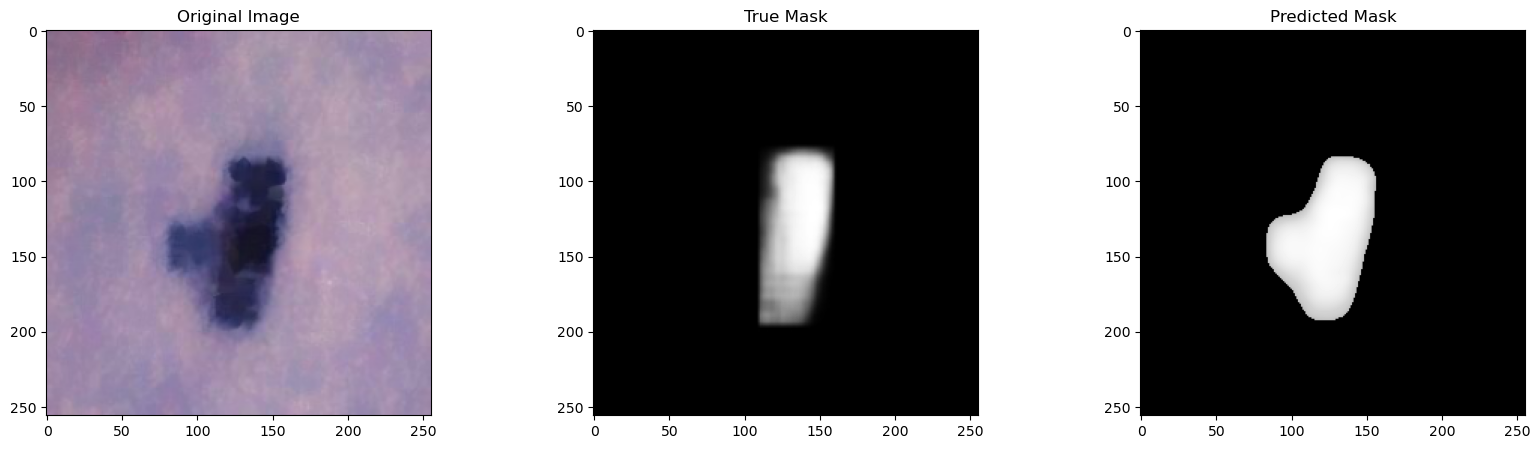

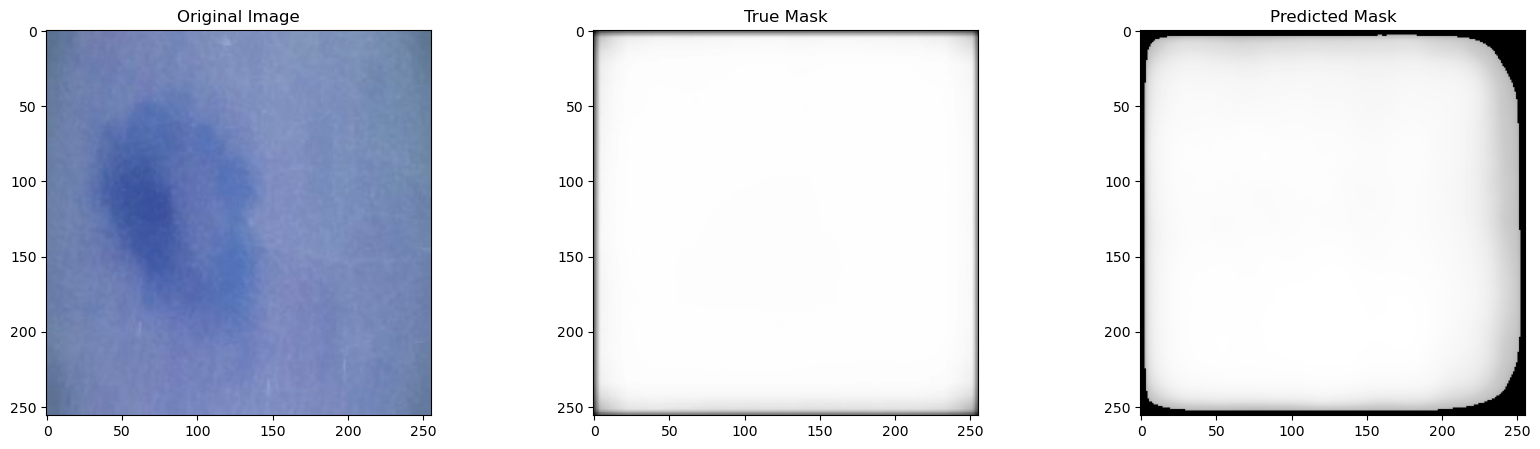

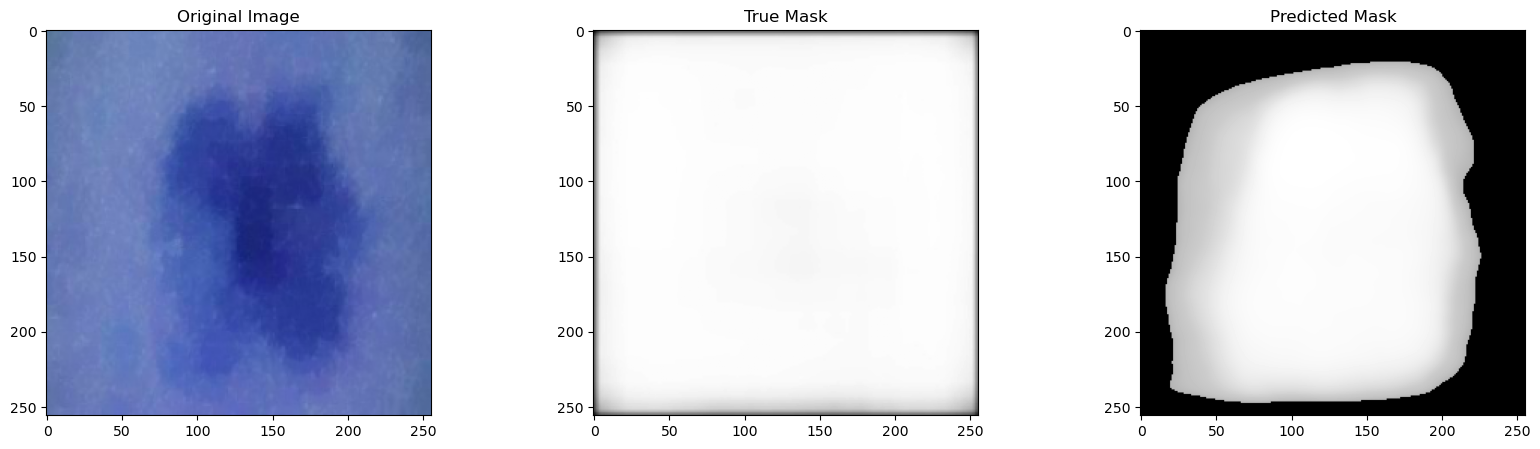

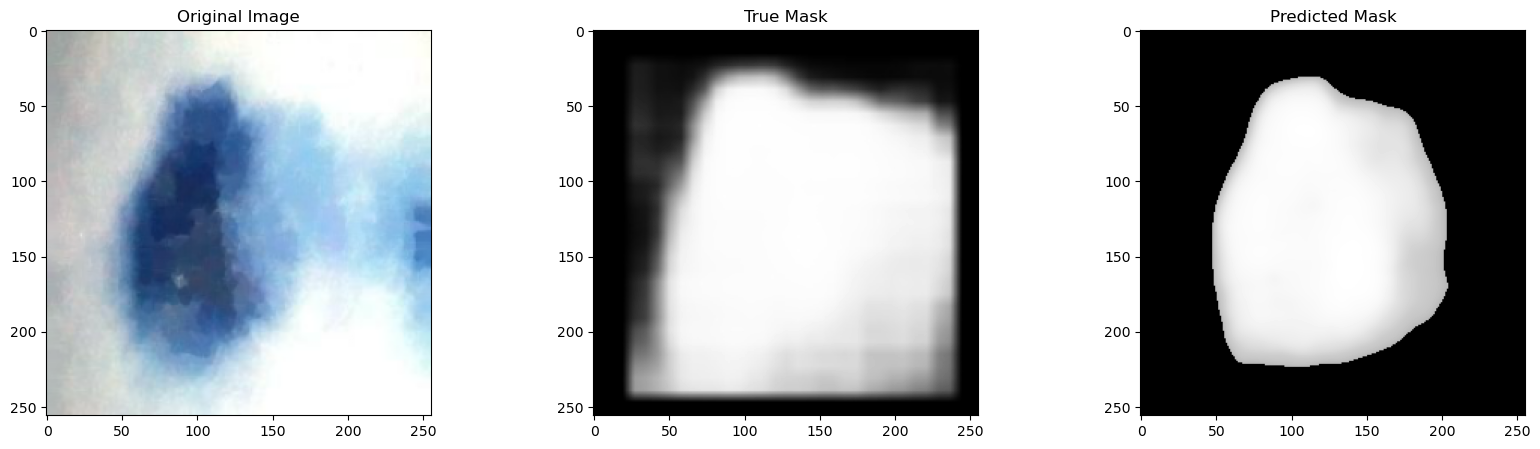

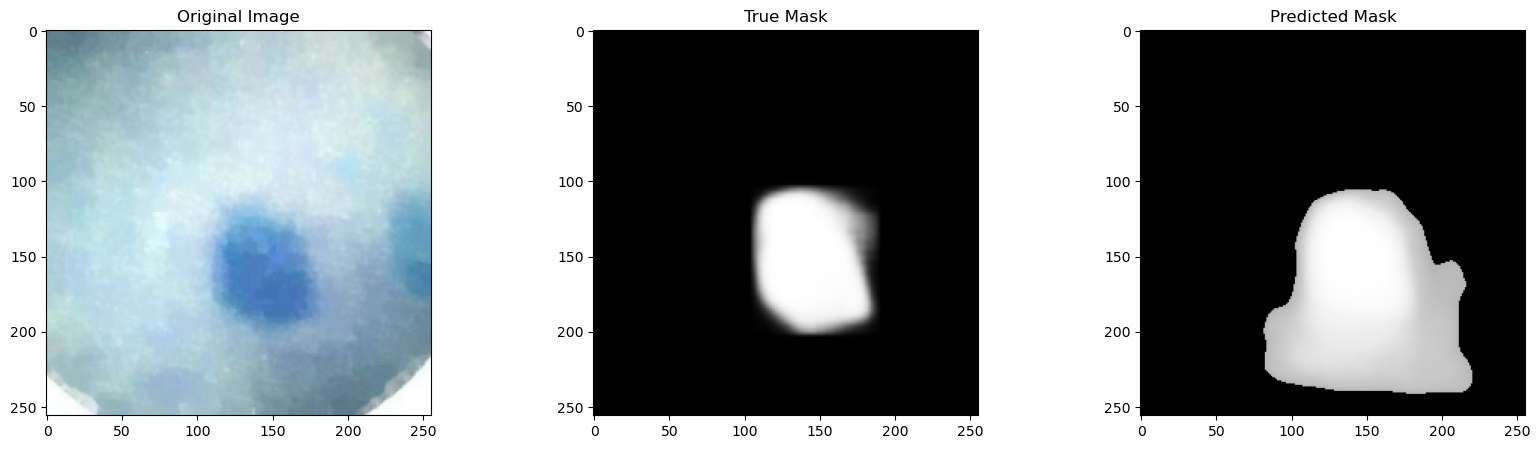

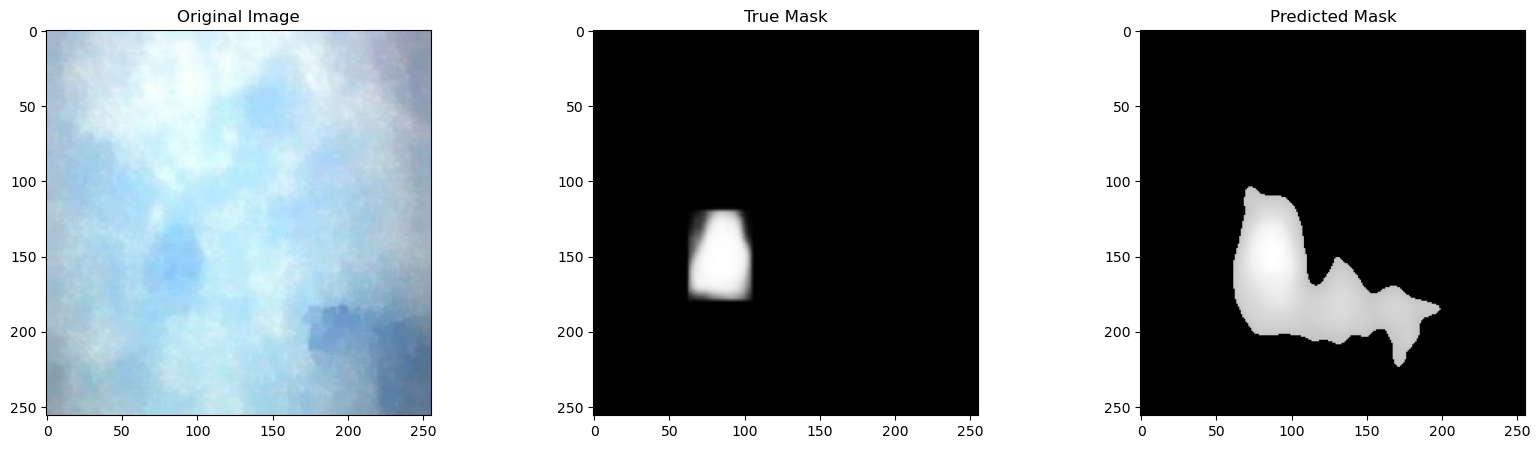

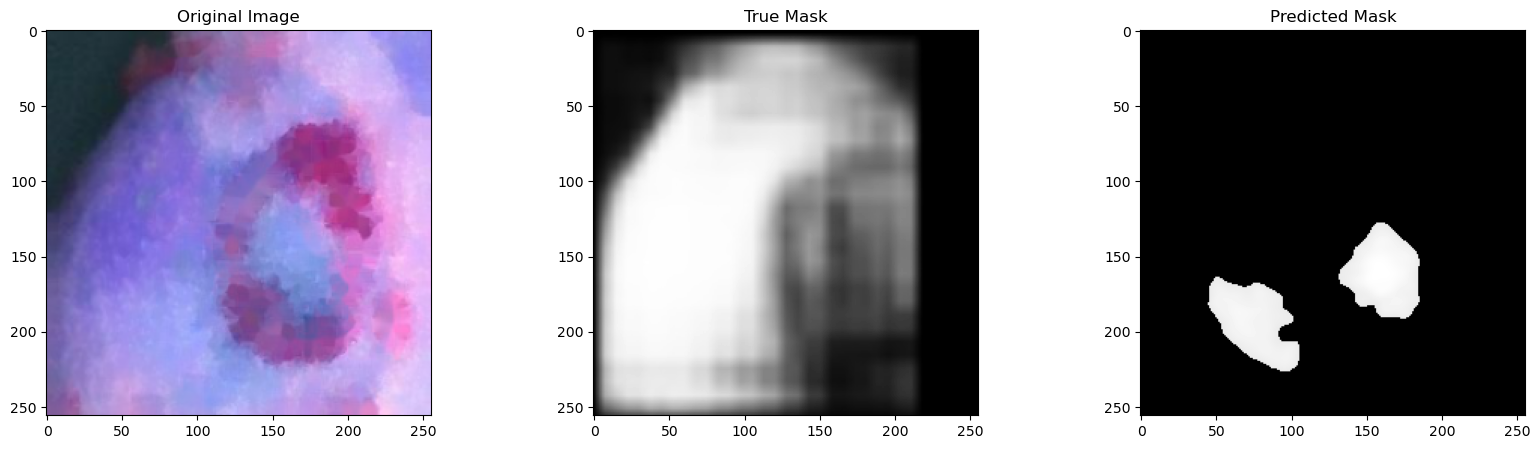

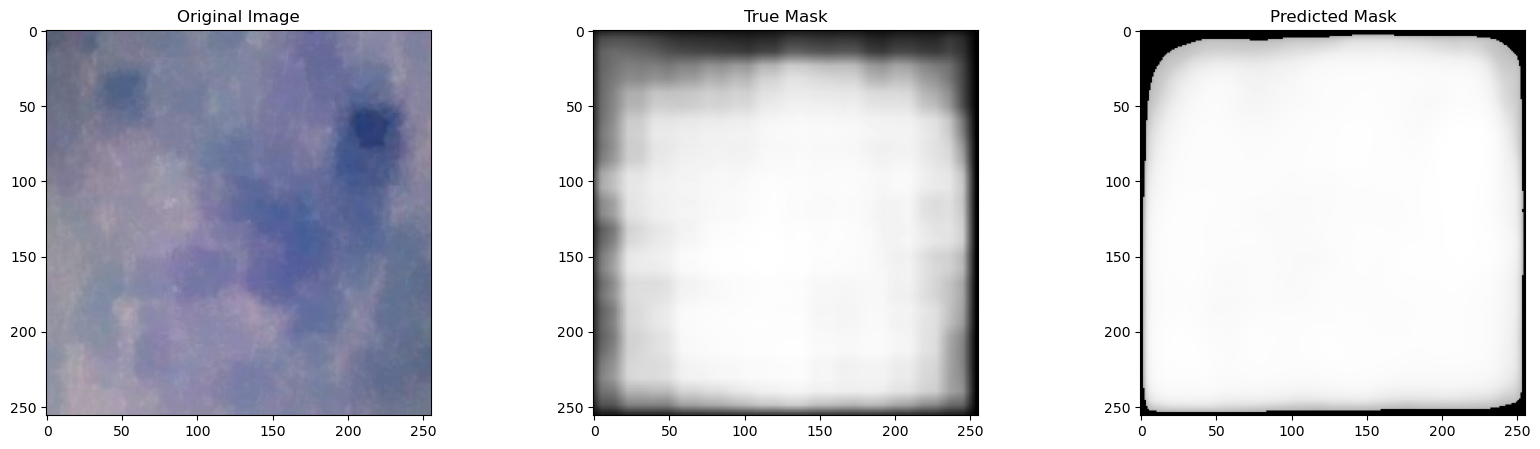

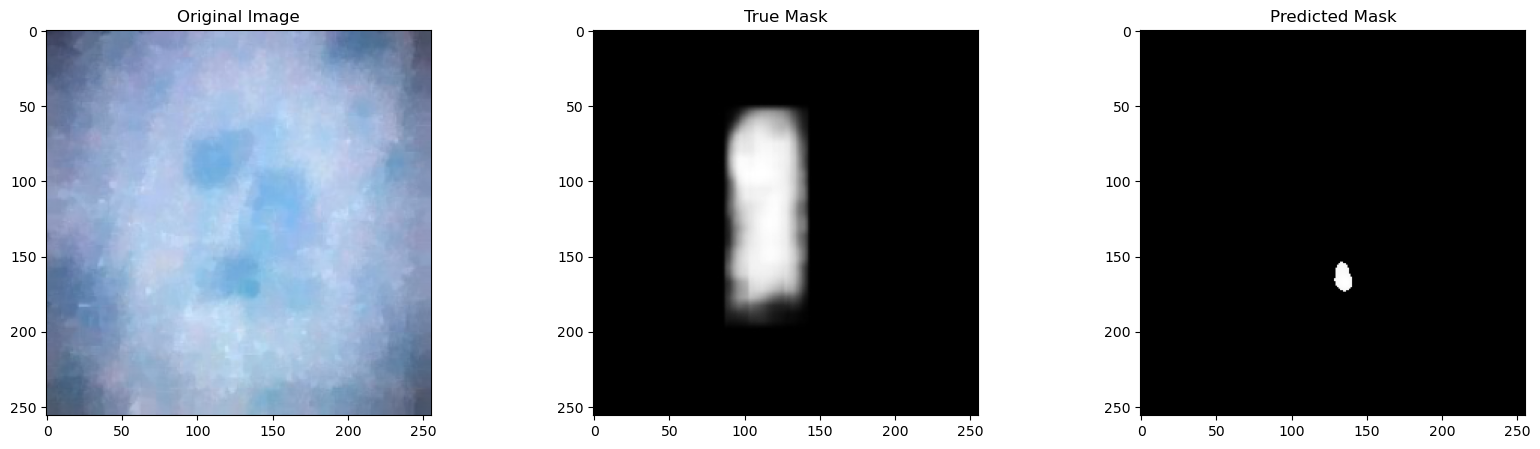

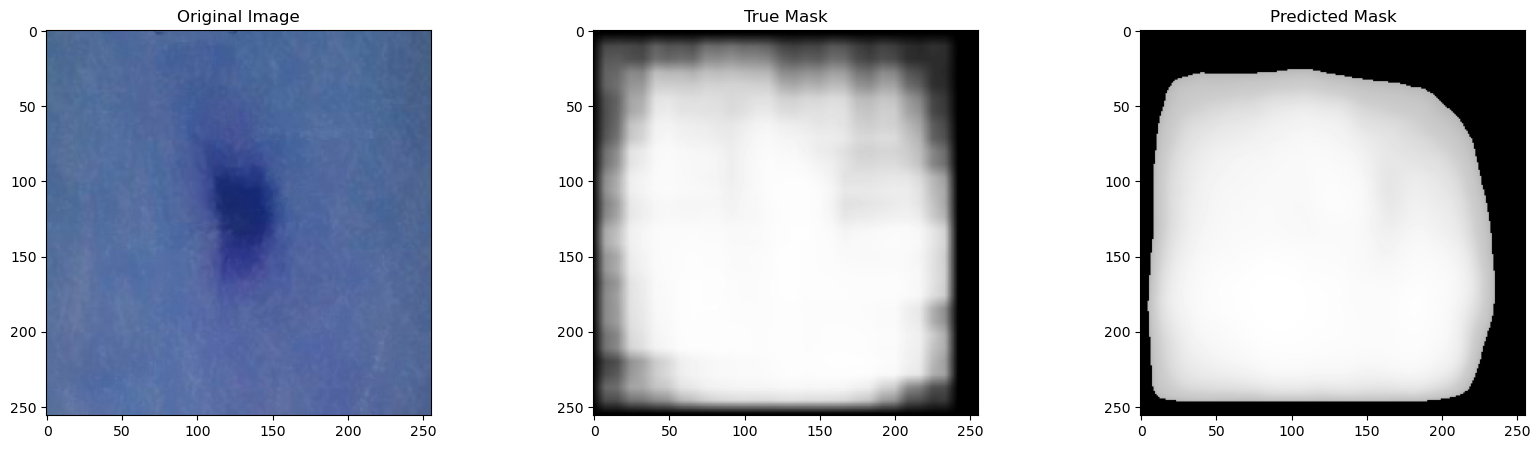

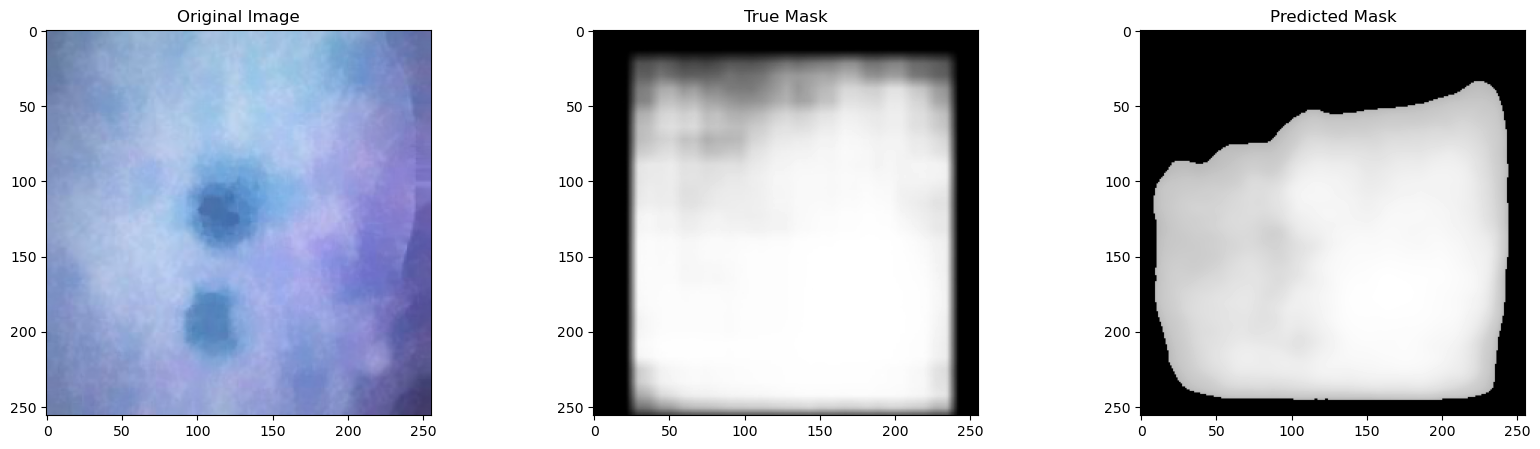

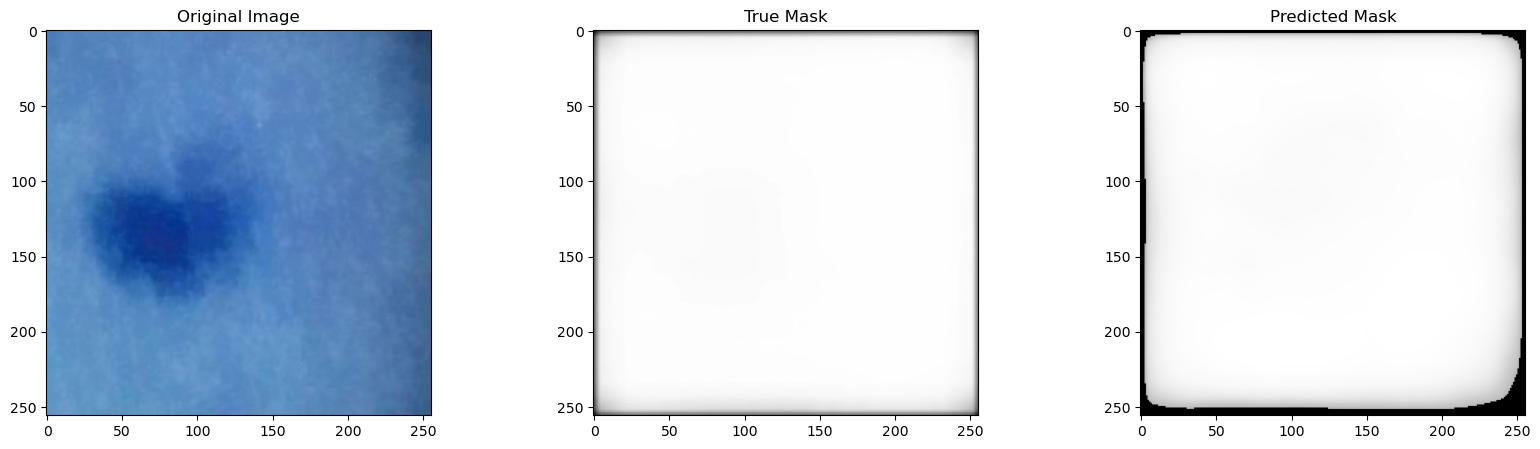

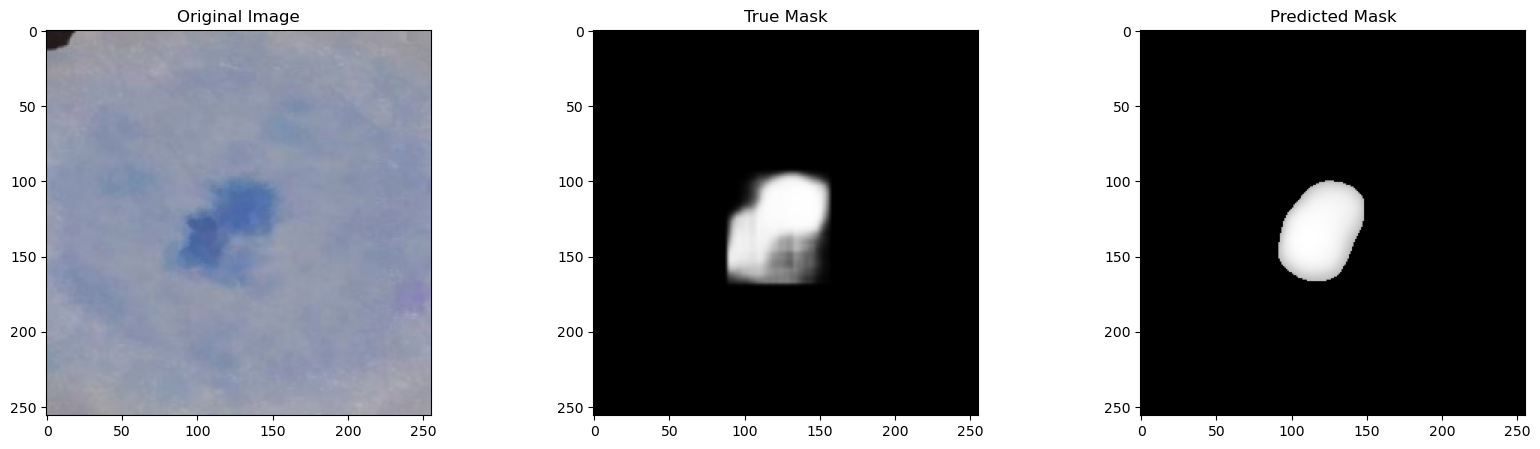

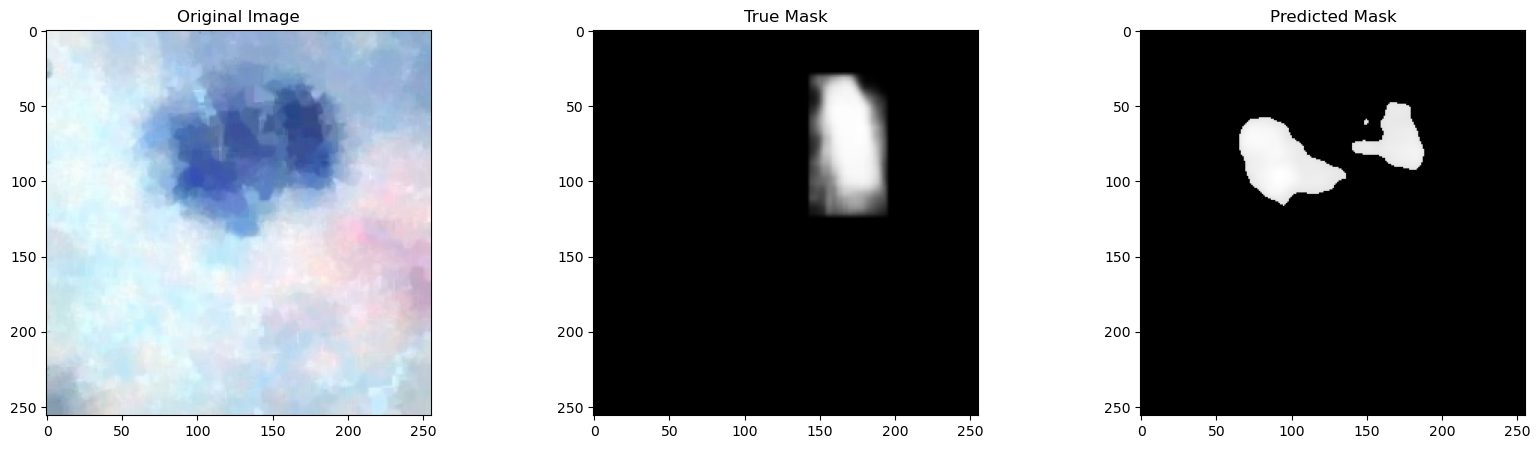

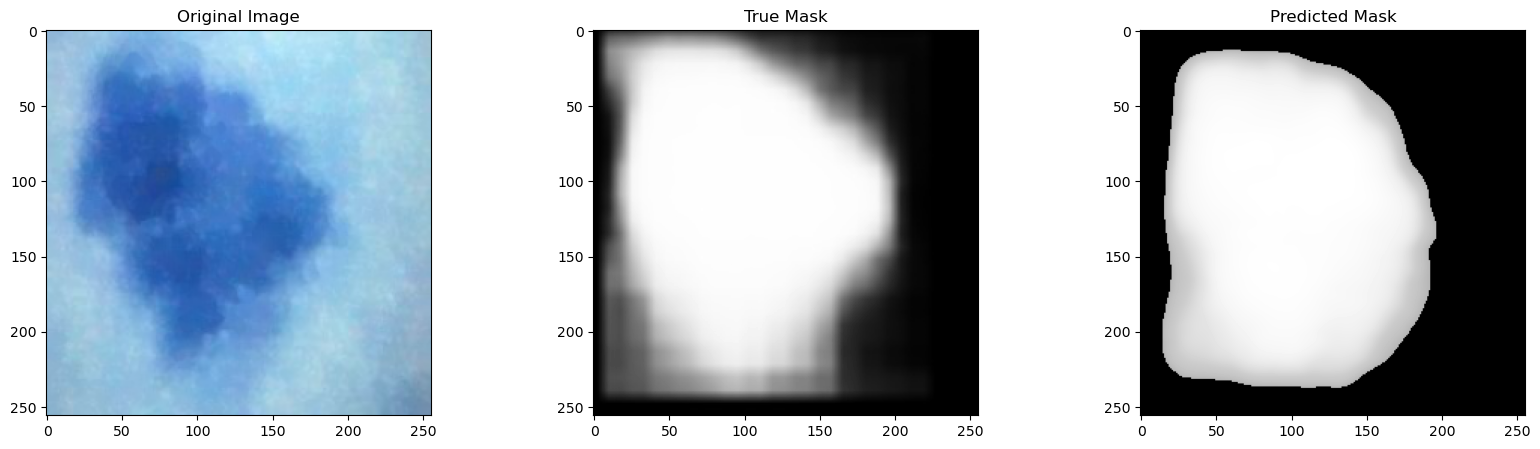

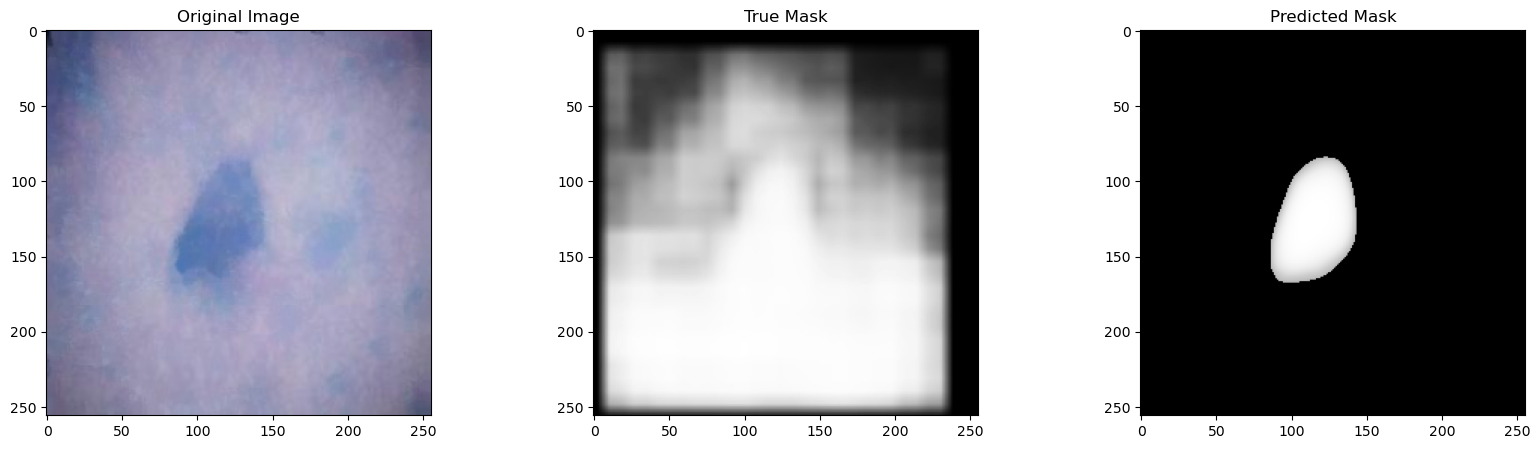

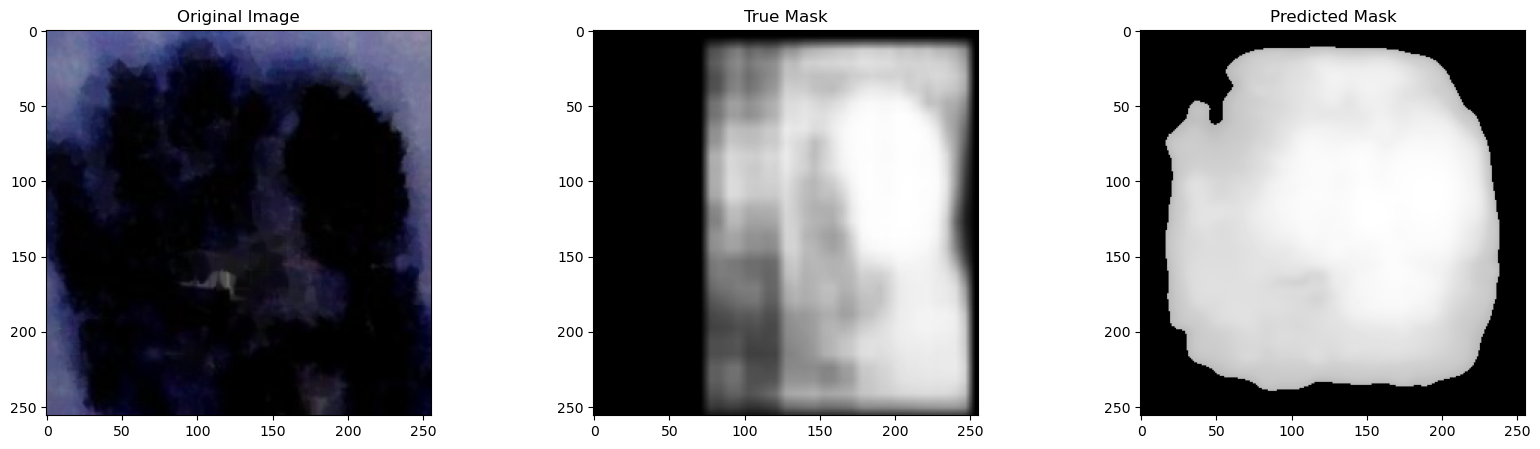

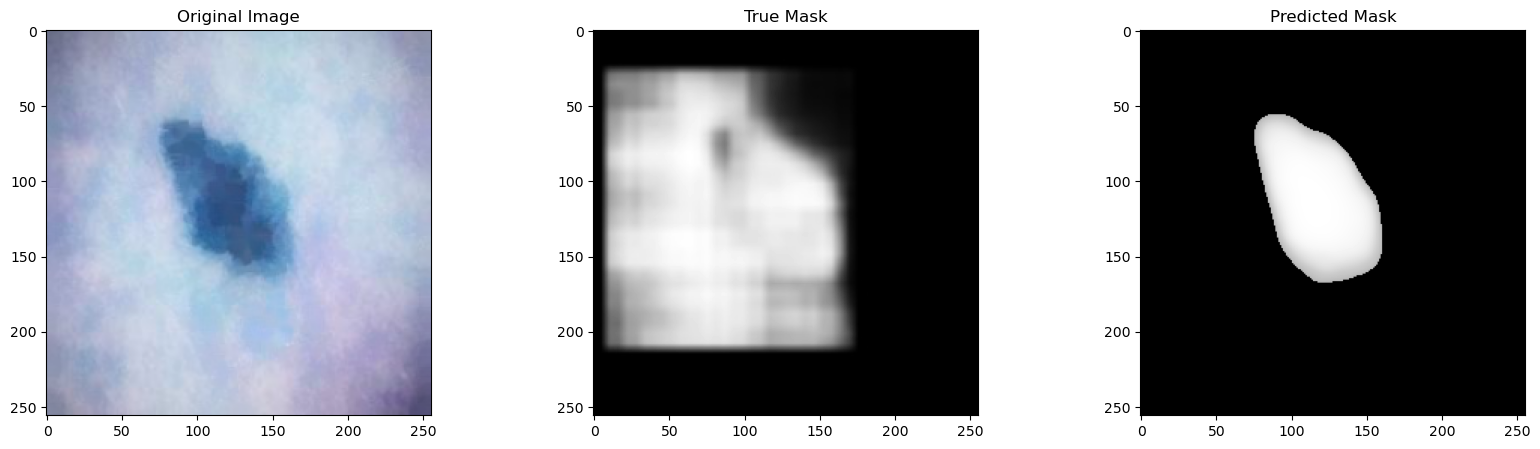

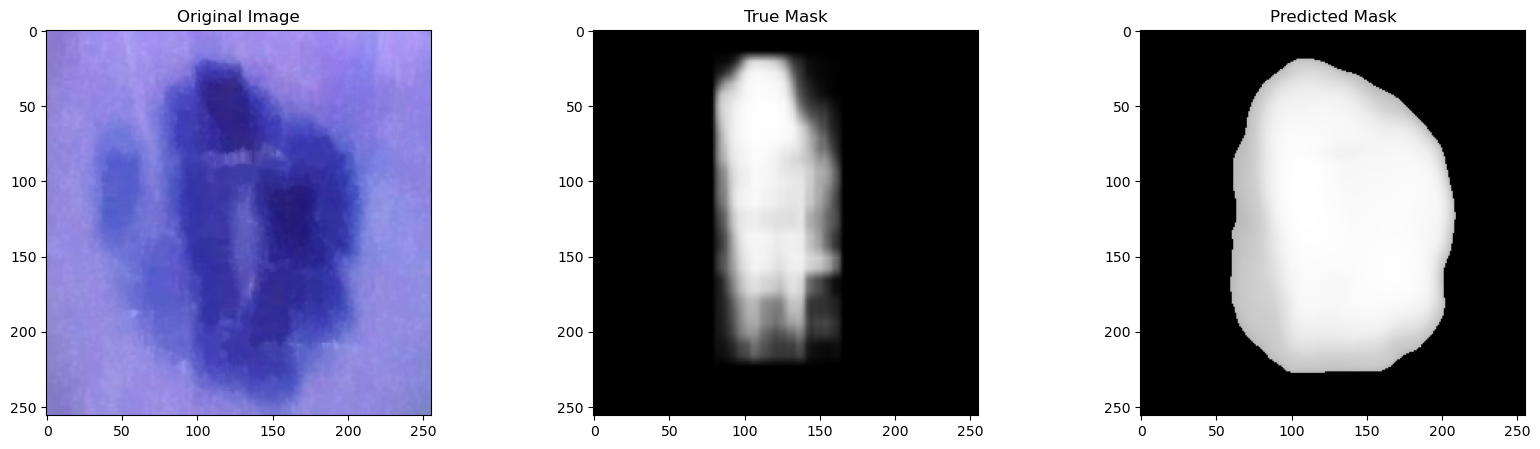

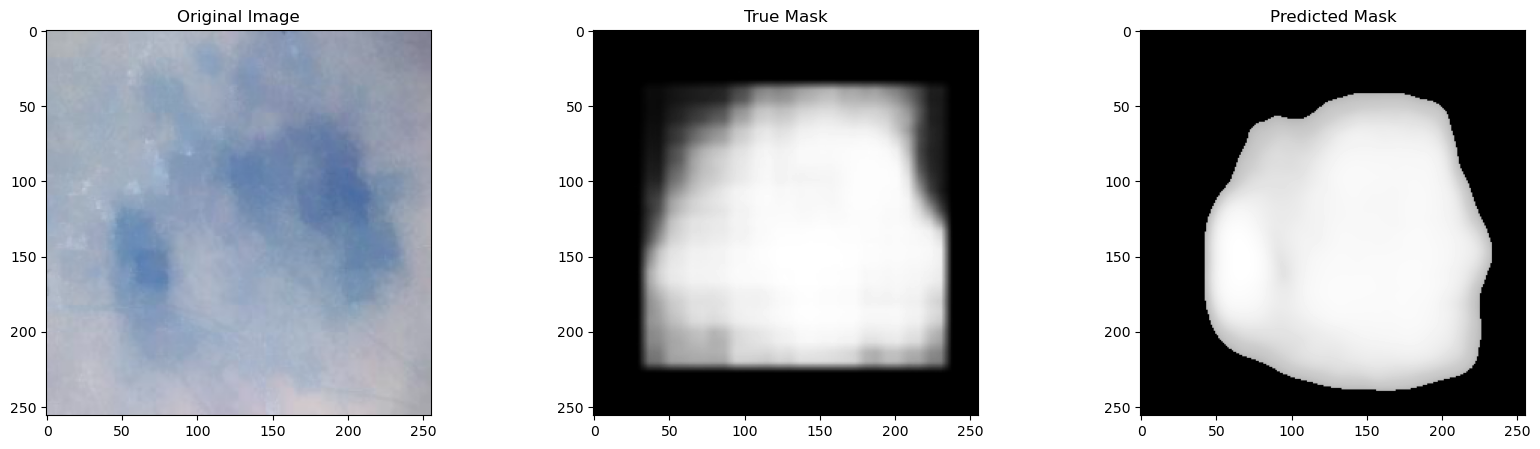

In [97]:
import random

def visualize_random_predictions(classifier, unet_model, data_loader, device, num_samples=20, threshold=0.5):
    # Set the models to evaluation mode
    classifier.eval()
    unet_model.eval()

    # Randomly select a subset of images from the data loader
    selected_images = random.sample(range(len(data_loader.dataset)), num_samples)

    with torch.no_grad():
        for idx in selected_images:
            # Retrieve the image and mask from the dataset
            image, mask = data_loader.dataset[idx]
            image = image.unsqueeze(0).to(device)
            mask = mask.unsqueeze(0).to(device)

            # Predict classification
            outputs = classifier(image)
            _, predicted = torch.max(outputs, 1)

            if predicted.item() == 1:  # If the image is classified as cancerous
                # Predict mask using the U-Net model
                mask_pred = unet_model(image)
                mask_pred = torch.sigmoid(mask_pred).squeeze().cpu().numpy()
                
                # Apply threshold
                mask_pred[mask_pred < threshold] = 0

                mask = mask.squeeze().cpu().numpy()
                
                # Plot the original image, true mask, and predicted mask
                plt.figure(figsize=(20, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
                plt.title('Original Image')

                plt.subplot(1, 3, 2)
                plt.imshow(mask, cmap='gray')
                plt.title('True Mask')

                plt.subplot(1, 3, 3)
                plt.imshow(mask_pred, cmap='gray')
                plt.title('Predicted Mask')
                plt.show()

# Execute the function to visualize the images
visualize_random_predictions(classifier, model, val_loader, device, num_samples=20, threshold=0.7)
